## Import Packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
sns.set()
%matplotlib inline

## Create Data Source

In [26]:
# Import data 
data_apr_27_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt")
data_may_04_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt")
data_may_11_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt")
data_may_18_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt")
data_may_25_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt")
data_jun_06_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt")
data_jun_08_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt")
data_jun_15_19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt")

# Combine data
all_data = pd.concat([data_apr_27_19, data_may_04_19, data_may_11_19, data_may_18_19, data_may_25_19
         , data_jun_06_19, data_jun_08_19, data_jun_15_19 ], ignore_index=True)

# Check that data imported successfully
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640586 entries, 0 to 1640585
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count    Dtype 
---  ------                                                                --------------    ----- 
 0   C/A                                                                   1640586 non-null  object
 1   UNIT                                                                  1640586 non-null  object
 2   SCP                                                                   1640586 non-null  object
 3   STATION                                                               1640586 non-null  object
 4   LINENAME                                                              1640586 non-null  object
 5   DIVISION                                                              1640586 non-null  object
 6   DATE                                                                  1640586 non-

## Clean and Prepare Data

In [27]:
### FILTERING, CLEANING, AND PREPARING DATA ###

# Filter data to only Regular scheduled audit events to remove any possible irregularities from recovered audits
all_data = all_data[all_data['DESC'] == 'REGULAR']

# Clean column names
all_data.columns = [column.strip() for column in all_data.columns]

# Create new variables to make datetime and turnstile easier to work with
all_data['DATETIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['TIME'])
all_data['DAYOFWEEK'] = all_data['DATETIME'].dt.day_name()
all_data['WEEKDAYNUMBER'] = all_data['DATETIME'].dt.dayofweek
all_data['TURNSTILE'] = all_data['C/A'] + all_data['UNIT'] + all_data['SCP'] + all_data['STATION']

# Sort data so it is in order of turnstile and datetime
all_data.sort_values(by = ['TURNSTILE', 'DATETIME'], inplace = True)

# Check for duplicate turnstile/datetime combinations
(all_data
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)


,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-04-20 00:00:00,1
1089203,R142,R293,01-06-00,34 ST-PENN STA,2019-05-12 02:00:00,1
1089201,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 18:00:00,1
1089200,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 14:00:00,1
1089199,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 10:00:00,1
1089198,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 06:00:00,1
1089197,R142,R293,01-06-00,34 ST-PENN STA,2019-05-11 02:00:00,1
1089196,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 22:00:00,1
1089195,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 18:00:00,1
1089194,R142,R293,01-06-00,34 ST-PENN STA,2019-05-10 14:00:00,1


## Check for Irregularities in Entries Data

In [6]:
### CHECKING FOR IRREGULARITIES IN CUMULATIVE ENTRIES DATA ###

# Aggregate data to daily level
turnstiles_daily = (all_data
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

# Calculate previous data and previous entries
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])
                        ["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))

# Check to see if entries from previous day are ever 
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
                        .groupby(["C/A", "UNIT", "SCP", "STATION"])
                        .size())


<ipython-input-6-196640c8757e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])


C/A   UNIT  SCP       STATION        
A025  R023  01-03-01  34 ST-HERALD SQ    55
A038  R085  00-00-01  8 ST-NYU            1
A043  R462  00-06-00  CANAL ST            1
A046  R463  00-00-03  CANAL ST            1
A049  R088  02-05-00  CORTLANDT ST       42
                                         ..
R621  R060  00-03-01  EASTN PKWY-MUSM     2
R622  R123  00-00-00  FRANKLIN AV        55
R629  R065  00-00-00  ROCKAWAY AV         1
R646  R110  01-00-01  FLATBUSH AV-B.C    55
R730  R431  00-00-04  EASTCHSTER/DYRE    51
Length: 481, dtype: int64

## Transform Entries and Exits Data

In [90]:
'''
Due to instances of previous daily turnstile entries that were higher than the current daily entries 
(see cell above), there was evidence that some counters were going backwards. 
Therefore, we used absolute value in net calculations
'''


# Resort data to ensure it is in correct order
all_data.sort_values(by = ['TURNSTILE', 'DATETIME'], inplace = True)

# Net entries and net exit calculations using absolute value
all_data['NET_ENTRIES'] = all_data.groupby('TURNSTILE')['ENTRIES'].diff().abs()
all_data['NET_EXITS'] = all_data.groupby('TURNSTILE')['EXITS'].diff().abs()

# Removing rows with entries or exits above 10,000 since anything over 10,000 entries or exits means that 
# at least 2,500 people went through that turnstile every hour for four hours straight and that seems unrealistic
indexNames = all_data[(all_data['NET_ENTRIES'] > 10000 ) | (all_data['NET_EXITS'] > 10000)].index
all_data_clean = all_data.drop(indexNames)

# Combine net entries and net exits into variable for all foot traffic
all_data_clean['TOTAL_FOOT_TRAFFIC'] = all_data_clean['NET_ENTRIES'] + all_data_clean['NET_EXITS']

# Verify data looks correct
all_data_clean.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAYOFWEEK,WEEKDAYNUMBER,TURNSTILE,NET_ENTRIES,NET_EXITS,TOTAL_FOOT_TRAFFIC
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,00:00:00,REGULAR,7026702,2382234,2019-04-20 00:00:00,Saturday,5,A002R05102-00-0059 ST,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,04:00:00,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,5,A002R05102-00-0059 ST,17.0,6.0,23.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,08:00:00,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,5,A002R05102-00-0059 ST,18.0,29.0,47.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,12:00:00,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,5,A002R05102-00-0059 ST,77.0,66.0,143.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/20/2019,16:00:00,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,5,A002R05102-00-0059 ST,193.0,60.0,253.0


## Data Visualization

In [29]:
# Daily Station Data
stations_daily = (all_data_clean.groupby(['STATION','DATE','DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].sum()
                 .reset_index())
stations_daily.head()

,STATION,DATE,DAYOFWEEK,WEEKDAYNUMBER,TOTAL_FOOT_TRAFFIC
0,1 AV,04/20/2019,Saturday,5,22404.0
1,1 AV,04/21/2019,Sunday,6,24402.0
2,1 AV,04/22/2019,Monday,0,35706.0
3,1 AV,04/23/2019,Tuesday,1,36389.0
4,1 AV,04/24/2019,Wednesday,2,37278.0


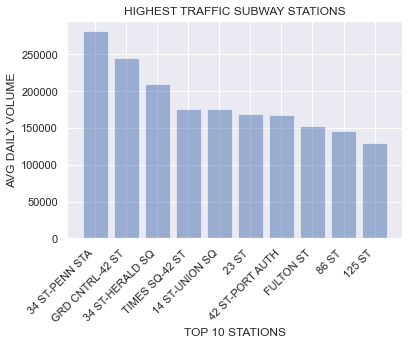

In [36]:
# Graph code for average foot traffic for top 10 station 

top10_stations = \
    (stations_daily.groupby(['STATION'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by='TOTAL_FOOT_TRAFFIC',ascending=False)
                   .head(10))

plt.bar(top10_stations['STATION'], top10_stations['TOTAL_FOOT_TRAFFIC'], align='center', alpha=0.5)
plt.xticks(top10_stations['STATION'], rotation=45, ha='right')
plt.ylabel('AVG DAILY VOLUME')
plt.xlabel('TOP 10 STATIONS')
plt.title('HIGHEST TRAFFIC SUBWAY STATIONS')
plt.show()

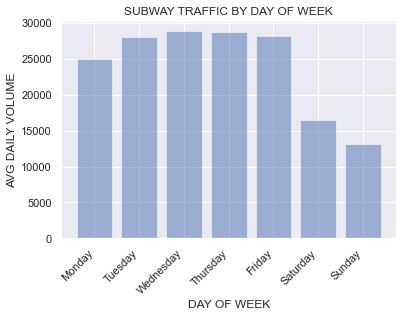

In [30]:
# Graph code for average foot traffic by day of week

dayofweek_avg = \
    (stations_daily.groupby(['DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by='WEEKDAYNUMBER')
                   )

plt.bar(dayofweek_avg['DAYOFWEEK'], dayofweek_avg['TOTAL_FOOT_TRAFFIC'], align='center', alpha=0.5)
plt.xticks(dayofweek_avg['DAYOFWEEK'], rotation=45, ha='right')
plt.ylabel('AVG DAILY VOLUME')
plt.xlabel('DAY OF WEEK')
plt.title('SUBWAY TRAFFIC BY DAY OF WEEK')
plt.show()

In [32]:
# Creating top 10 stations data subset of original data

top10_stations_daily = stations_daily[stations_daily['STATION'].isin(top10_stations['STATION'])]
top10_stations_daily.head()

,STATION,DATE,DAYOFWEEK,WEEKDAYNUMBER,TOTAL_FOOT_TRAFFIC
504,125 ST,04/20/2019,Saturday,5,77333.0
505,125 ST,04/21/2019,Sunday,6,85126.0
506,125 ST,04/22/2019,Monday,0,122196.0
507,125 ST,04/23/2019,Tuesday,1,132198.0
508,125 ST,04/24/2019,Wednesday,2,135199.0


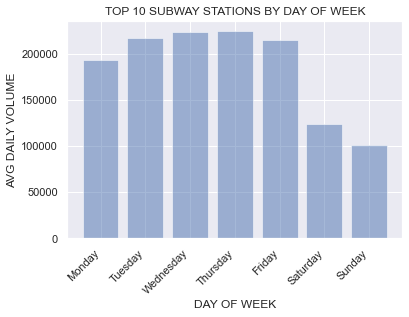

In [33]:
# Graph code for average foot traffic by day of week for top 10 stations only

dayofweek_station_avg = \
    (top10_stations_daily.groupby(['DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by ='WEEKDAYNUMBER')
                   )

plt.bar(dayofweek_station_avg['DAYOFWEEK'], dayofweek_station_avg['TOTAL_FOOT_TRAFFIC'], align='center', alpha=0.5)
plt.xticks(dayofweek_station_avg['DAYOFWEEK'], rotation=45, ha='right')
plt.ylabel('AVG DAILY VOLUME')
plt.xlabel('DAY OF WEEK')
plt.title('TOP 10 SUBWAY STATIONS BY DAY OF WEEK')
plt.show()

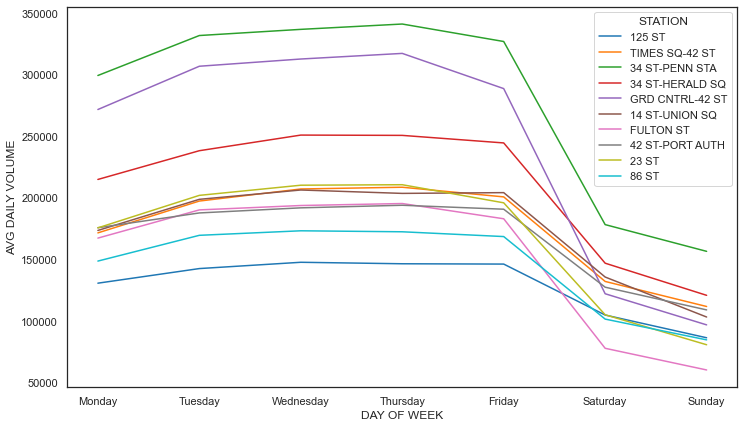

In [89]:
# Top 10 stations grouped by weekday and graphed

top10_stations_weekday_avg = \
    (top10_stations_daily.groupby(['STATION', 'DAYOFWEEK', 'WEEKDAYNUMBER'])['TOTAL_FOOT_TRAFFIC'].mean()
                   .reset_index()
                   .sort_values(by ='WEEKDAYNUMBER')
                   )


sns.set_palette('tab10',10)
sns.set_style("white")
plt.figure(figsize=(12, 7))
plt.xlabel('DAY OF WEEK')
plt.ylabel('AVG DAILY VOLUME')
sns.lineplot(x="DAYOFWEEK", y="TOTAL_FOOT_TRAFFIC", hue="STATION", data = top10_stations_weekday_avg);


## Other Code 
##### Just in case we need it, I can delete it if we don't

In [ ]:
# Wonjae's code by four hour period
four_hr = (all_data_clean.groupby(['DATETIME','TURNSTILE'])['TOTAL_FOOT_TRAFFIC'].sum()
              .reset_index()
              .sort_values(by='TOTAL_FOOT_TRAFFIC'
                           ,ascending=False))
four_hr.head(25)

In [ ]:
## Other code

top10_stations = \
    (stations_daily.groupby(['STATION'])['TOTAL_FOOT_TRAFFIC'].sum()
                   .reset_index()
                   .sort_values(by='TOTAL_FOOT_TRAFFIC',ascending=False)
                   .STATION.head(10))
top10_stations

stations_daily_top10 = \
    stations_daily[stations_daily[‘STATION’].isin(top10_stations)]





# use seaborn to create a boxplot by station
sns.boxplot(‘total_foot_traffic’, ‘STATION’, data=stations_daily_top10)

df_weekday = (stations_daily.groupby([‘day_of_week’])[‘total_foot_traffic’].sum()
              .reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))
(stations_daily.query(‘STATION == “34 ST-PENN STA”’).reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))

sns.distplot(turnstiles_daily[‘ENTRIES’]
             [turnstiles_daily[‘ENTRIES’] < 50000])

(stations_daily.query(‘STATION == “GRD CNTRL-42 ST”’).reset_index()
              .sort_values(by=‘total_foot_traffic’
                           ,ascending=False))